# Import the neccesary libraries

In [33]:
import kagglehub
from pymongo import MongoClient
import os
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Downloading Dataset from kaggle

In [2]:
# Download latest version
path = kagglehub.dataset_download("michaelminhpham/vietnamese-tiki-e-commerce-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\michaelminhpham\vietnamese-tiki-e-commerce-dataset\versions\10


In [3]:
pip install pymongo pandas

Note: you may need to restart the kernel to use updated packages.


## Connecting MongoDb

In [4]:
# MongoDB connection string (update with your MongoDB URI)
client = MongoClient("mongodb://localhost:27017/")

# Specify the database name
db = client["ecommerce_db"]

print("Connected to MongoDB successfully!")

Connected to MongoDB successfully!


## Importing data from csv to MongoDb database

In [5]:
MONGO_URI = "mongodb://localhost:27017" 
DATABASE_NAME = "ecommerce_db"  # Name of the database

# Directory where CSV files are stored
csv_directory = "C:/Users/Admin/.cache/kagglehub/datasets/michaelminhpham/vietnamese-tiki-e-commerce-dataset/versions/10"

# Initialize MongoDB client
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

# Function to load CSV into MongoDB
def load_csv_to_mongo(csv_file, collection_name):
    try:
        # Read CSV file into a pandas DataFrame
        data = pd.read_csv(os.path.join(csv_directory, csv_file))
        
        # Convert DataFrame to dictionary records
        records = data.to_dict(orient='records')
        
        # Insert records into MongoDB collection
        collection = db[collection_name]
        collection.insert_many(records)
        print(f"Successfully inserted {len(records)} records into {collection_name} collection.")
    except Exception as e:
        print(f"Error loading {csv_file}: {e}")

# List of CSV files and corresponding collection names
csv_files = {
    "vietnamese_tiki_products_backpacks_suitcases.csv": "backpacks_suitcases",
    "vietnamese_tiki_products_fashion_accessories.csv": "fashion_accessories",
    "vietnamese_tiki_products_men_bags.csv": "men_bags",
    "vietnamese_tiki_products_men_shoes.csv": "men_shoes",
    "vietnamese_tiki_products_women_bags.csv": "women_bags",
    "vietnamese_tiki_products_women_shoes.csv": "women_shoes",
}

# Load each CSV file into MongoDB
for csv_file, collection_name in csv_files.items():
    load_csv_to_mongo(csv_file, collection_name)

# Close the MongoDB connection
client.close()

Successfully inserted 5361 records into backpacks_suitcases collection.
Successfully inserted 16019 records into fashion_accessories collection.
Successfully inserted 4234 records into men_bags collection.
Successfully inserted 5745 records into men_shoes collection.
Successfully inserted 4325 records into women_bags collection.
Successfully inserted 5919 records into women_shoes collection.


## Data Pre-processing

In [7]:
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

# List of collection names
collections = [
    "backpacks_suitcases",
    "fashion_accessories",
    "men_bags",
    "men_shoes",
    "women_bags",
    "women_shoes",
]

# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

def preprocess_collection(data):
    # Drop the MongoDB `_id` column if it exists
    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    # Remove duplicate rows
    data = data.drop_duplicates()
    
    # Drop columns with all zero values
    cols_with_all_zeros = [col for col in data.columns if (data[col] == 0).all()]
    data = data.drop(columns=cols_with_all_zeros)
    
    # Return cleaned data and list of zero-value columns removed
    return data, cols_with_all_zeros

# Load, preprocess, and save both cleaned and uncleaned data
all_data = {}
cols_to_remove_globally = set()

for collection_name in collections:
    print(f"Processing collection: {collection_name}")
    # Load data from MongoDB into a DataFrame
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))
    
    # Preprocess the data
    cleaned_data, cols_with_all_zeros = preprocess_collection(data)
    
    # Keep track of columns to be removed globally
    cols_to_remove_globally.update(cols_with_all_zeros)
    all_data[collection_name] = {"original": data, "cleaned": cleaned_data}

for collection_name, data_versions in all_data.items():
    # Drop globally identified columns from the cleaned version
    cleaned_data = data_versions["cleaned"].drop(columns=list(cols_to_remove_globally), errors="ignore")
    
    # Save cleaned data
    collection_cleaned = db[f"{collection_name}_cleaned"]
    collection_cleaned.delete_many({})  # Clear existing data if overwriting
    if not cleaned_data.empty:
        collection_cleaned.insert_many(cleaned_data.to_dict("records"))
        print(f"Saved cleaned data to collection: {collection_name}_cleaned")

# Close MongoDB connection
client.close()

print(f"Columns removed globally: {cols_to_remove_globally}")

Processing collection: backpacks_suitcases
Processing collection: fashion_accessories
Processing collection: men_bags
Processing collection: men_shoes
Processing collection: women_bags
Processing collection: women_shoes
Saved cleaned data to collection: backpacks_suitcases_cleaned
Saved cleaned data to collection: fashion_accessories_cleaned
Saved cleaned data to collection: men_bags_cleaned
Saved cleaned data to collection: men_shoes_cleaned
Saved cleaned data to collection: women_bags_cleaned
Saved cleaned data to collection: women_shoes_cleaned
Columns removed globally: {'favourite_count'}


## Data transforming and storing data in database

In [8]:
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

cleaned_collections = [
    "backpacks_suitcases_cleaned",
    "fashion_accessories_cleaned",
    "men_bags_cleaned",
    "men_shoes_cleaned",
    "women_bags_cleaned",
    "women_shoes_cleaned",
]

client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

def flatten_json(data):
    return pd.json_normalize(data)

def feature_engineering(data):

    if 'original_price' in data.columns and 'price' in data.columns:
        data['discount_percent'] = ((data['original_price'] - data['price']) / data['original_price']) * 100
    

    if 'price' in data.columns:
        bins = [0, 100, 500, 1000, 5000, float('inf')]
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        data['price_range'] = pd.cut(data['price'], bins=bins, labels=labels, include_lowest=True)
    
    if 'discount_percent' in data.columns:
        data['heavily_discounted'] = data['discount_percent'] > 50
    
    if 'product_name' in data.columns and 'category' in data.columns:
        data['full_description'] = data['category'] + " - " + data['product_name']
    
    return data

for collection_name in cleaned_collections:
    print(f"Processing collection: {collection_name}")

    collection = db[collection_name]
    raw_data = list(collection.find())
    if not raw_data:
        print(f"No data found in collection: {collection_name}")
        continue

    data = pd.DataFrame(raw_data)

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    if any(data.applymap(lambda x: isinstance(x, (dict, list))).any()):
        data = flatten_json(data)

    transformed_data = feature_engineering(data)

    transformed_collection_name = collection_name.replace("_cleaned", "_transformed")
    transformed_collection = db[transformed_collection_name]
    transformed_collection.delete_many({})
    transformed_collection.insert_many(transformed_data.to_dict("records"))
    print(f"Transformed data saved to collection: {transformed_collection_name}")

client.close()

Processing collection: backpacks_suitcases_cleaned
Transformed data saved to collection: backpacks_suitcases_transformed
Processing collection: fashion_accessories_cleaned
Transformed data saved to collection: fashion_accessories_transformed
Processing collection: men_bags_cleaned
Transformed data saved to collection: men_bags_transformed
Processing collection: men_shoes_cleaned
Transformed data saved to collection: men_shoes_transformed
Processing collection: women_bags_cleaned
Transformed data saved to collection: women_bags_transformed
Processing collection: women_shoes_cleaned
Transformed data saved to collection: women_shoes_transformed


In [9]:
print(data.dtypes)

Unnamed: 0               int64
id                       int64
name                    object
description             object
original_price           int64
price                    int64
fulfillment_type        object
brand                   object
review_count             int64
rating_average         float64
pay_later                 bool
current_seller          object
date_created             int64
number_of_images         int64
vnd_cashback             int64
has_video                 bool
category                object
quantity_sold            int64
discount_percent       float64
price_range           category
heavily_discounted        bool
dtype: object


# EDA

Summary Statistics for backpacks_suitcases_transformed:
         Unnamed: 0            id                              name  \
count   5361.000000  5.361000e+03                              5361   
unique          NaN           NaN                              5014   
top             NaN           NaN  Balo túi rút thời trang chất bền   
freq            NaN           NaN                                13   
mean    2680.000000  1.515822e+08                               NaN   
std     1547.731727  7.492765e+07                               NaN   
min        0.000000  4.766080e+05                               NaN   
25%     1340.000000  9.932188e+07                               NaN   
50%     2680.000000  1.674104e+08                               NaN   
75%     4020.000000  2.008020e+08                               NaN   
max     5360.000000  2.632082e+08                               NaN   

       description  original_price         price fulfillment_type brand  \
count         53

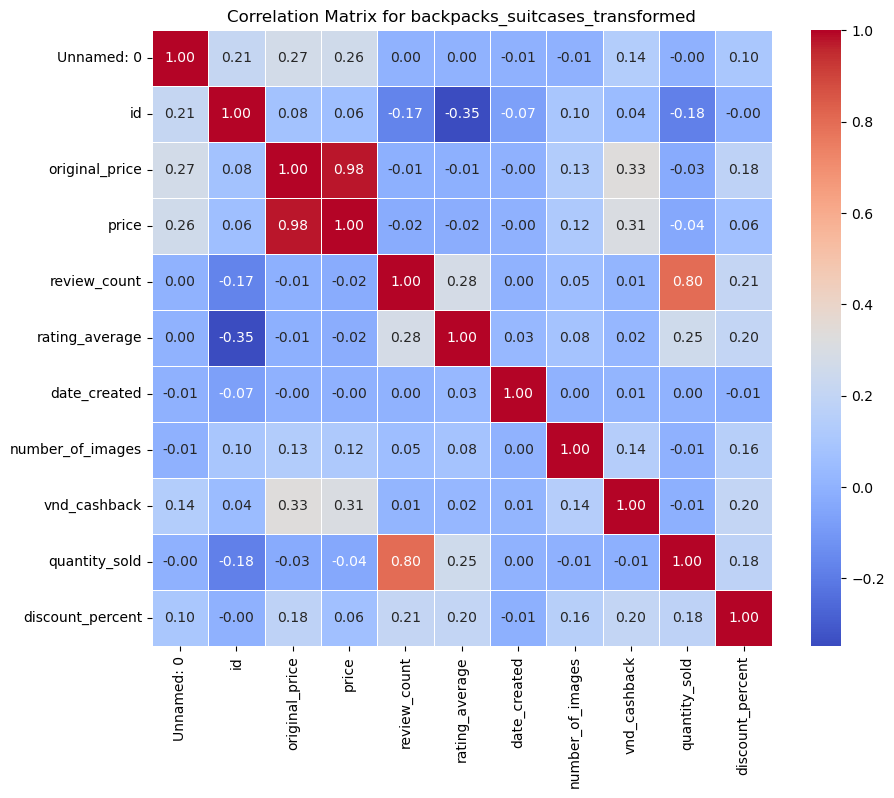

In [24]:
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

transformed_collections = [
    "backpacks_suitcases_transformed"
]

client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

def perform_eda(collection_name):

    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))
    
    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    print(f"Summary Statistics for {collection_name}:")
    print(data.describe(include='all'))

    print(f"\nMissing values in {collection_name}:")
    print(data.isnull().sum())

    print(f"\nCorrelation analysis for {collection_name}:")
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    if len(numerical_columns) > 0:
        correlation_matrix = data[numerical_columns].corr()
        print(correlation_matrix)
        
        # Plot correlation matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
        plt.title(f"Correlation Matrix for {collection_name}")
        plt.show()
    else:
        print("No numerical columns found for correlation analysis.")

for collection_name in transformed_collections:
    perform_eda(collection_name)

client.close()

Summary Statistics for fashion_accessories_transformed:
          Unnamed: 0            id  \
count   16019.000000  1.601900e+04   
unique           NaN           NaN   
top              NaN           NaN   
freq             NaN           NaN   
mean     8009.000000  1.430643e+08   
std      4624.431316  6.078759e+07   
min         0.000000  7.078190e+05   
25%      4004.500000  1.003783e+08   
50%      8009.000000  1.447051e+08   
75%     12013.500000  1.916462e+08   
max     16018.000000  2.633026e+08   

                                                    name description  \
count                                              16019       16019   
unique                                             14795       11389   
top     Khăn Voan Choàng Nữ XK Phong Cách Cá Tính 206251         ...   
freq                                                  14         358   
mean                                                 NaN         NaN   
std                                                  Na

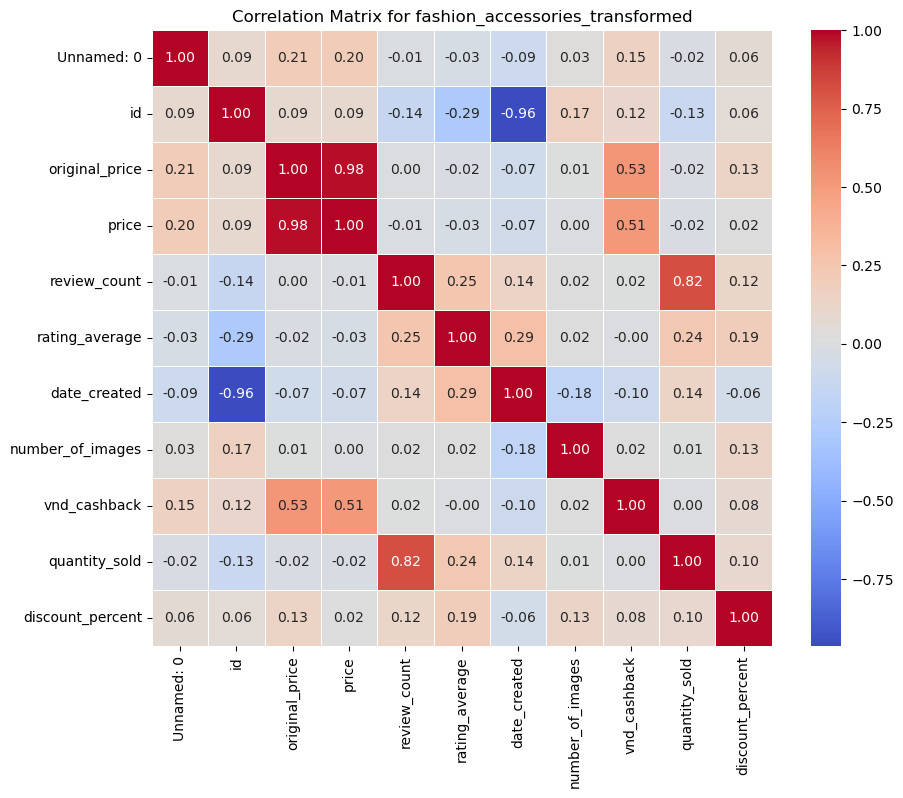

In [23]:
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

transformed_collections = [
    "fashion_accessories_transformed"
]

client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

def perform_eda(collection_name):

    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    print(f"Summary Statistics for {collection_name}:")
    print(data.describe(include='all'))

    print(f"\nMissing values in {collection_name}:")
    print(data.isnull().sum())

    print(f"\nCorrelation analysis for {collection_name}:")
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    if len(numerical_columns) > 0:
        correlation_matrix = data[numerical_columns].corr()
        print(correlation_matrix)

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
        plt.title(f"Correlation Matrix for {collection_name}")
        plt.show()
    else:
        print("No numerical columns found for correlation analysis.")

for collection_name in transformed_collections:
    perform_eda(collection_name)

client.close()

Summary Statistics for men_bags_transformed:
         Unnamed: 0            id  \
count   4234.000000  4.234000e+03   
unique          NaN           NaN   
top             NaN           NaN   
freq            NaN           NaN   
mean    2116.500000  1.403919e+08   
std     1222.394849  6.526280e+07   
min        0.000000  5.949770e+05   
25%     1058.250000  9.167138e+07   
50%     2116.500000  1.462669e+08   
75%     3174.750000  1.889963e+08   
max     4233.000000  2.631043e+08   

                                                 name  \
count                                            4234   
unique                                           3905   
top     Ví nam nữ cao cấp kiểu dáng sang trọng 204449   
freq                                               11   
mean                                              NaN   
std                                               NaN   
min                                               NaN   
25%                                               NaN 

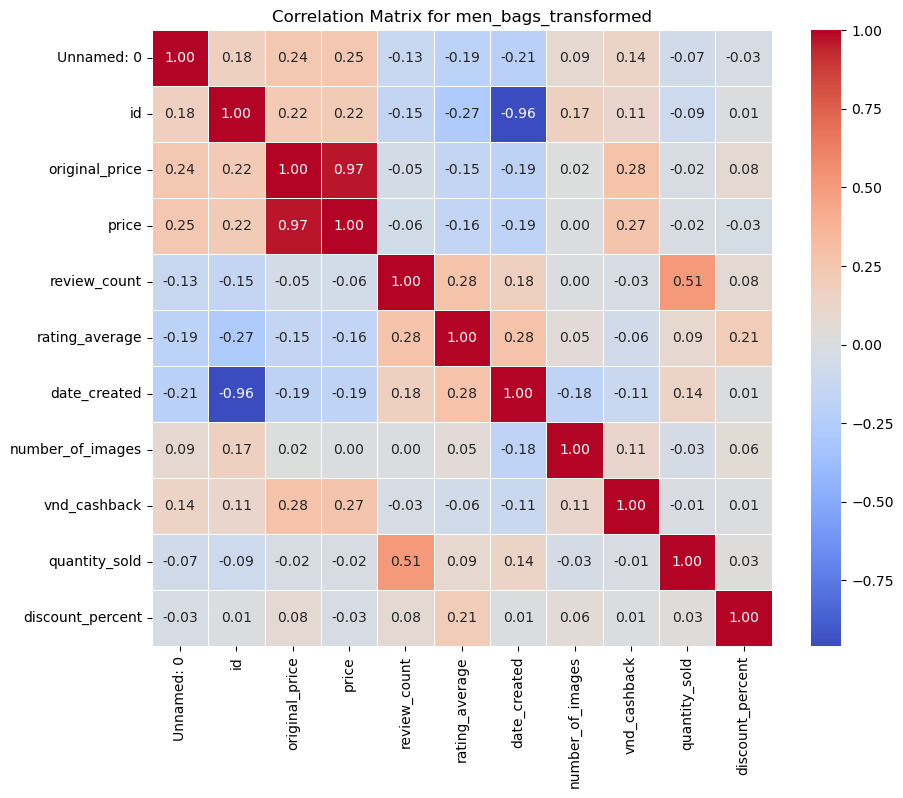

In [25]:
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

transformed_collections = [
    "men_bags_transformed"
]

client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

def perform_eda(collection_name):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    # Display basic statistics
    print(f"Summary Statistics for {collection_name}:")
    print(data.describe(include='all'))

    print(f"\nMissing values in {collection_name}:")
    print(data.isnull().sum())

    print(f"\nCorrelation analysis for {collection_name}:")
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    if len(numerical_columns) > 0:
        correlation_matrix = data[numerical_columns].corr()
        print(correlation_matrix)

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
        plt.title(f"Correlation Matrix for {collection_name}")
        plt.show()
    else:
        print("No numerical columns found for correlation analysis.")

for collection_name in transformed_collections:
    perform_eda(collection_name)

client.close()

Summary Statistics for men_shoes_transformed:
        Unnamed: 0            id  \
count   5745.00000  5.745000e+03   
unique         NaN           NaN   
top            NaN           NaN   
freq           NaN           NaN   
mean    2872.00000  1.508055e+08   
std     1658.58298  5.956208e+07   
min        0.00000  7.992790e+05   
25%     1436.00000  1.097873e+08   
50%     2872.00000  1.576533e+08   
75%     4308.00000  1.959922e+08   
max     5744.00000  2.630827e+08   

                                                     name description  \
count                                                5745        5745   
unique                                               5020        3880   
top     Giày tây Giày lười Da Nam Bóng Đai Kim Loại Ch...         ...   
freq                                                   12         210   
mean                                                  NaN         NaN   
std                                                   NaN         NaN   
min       

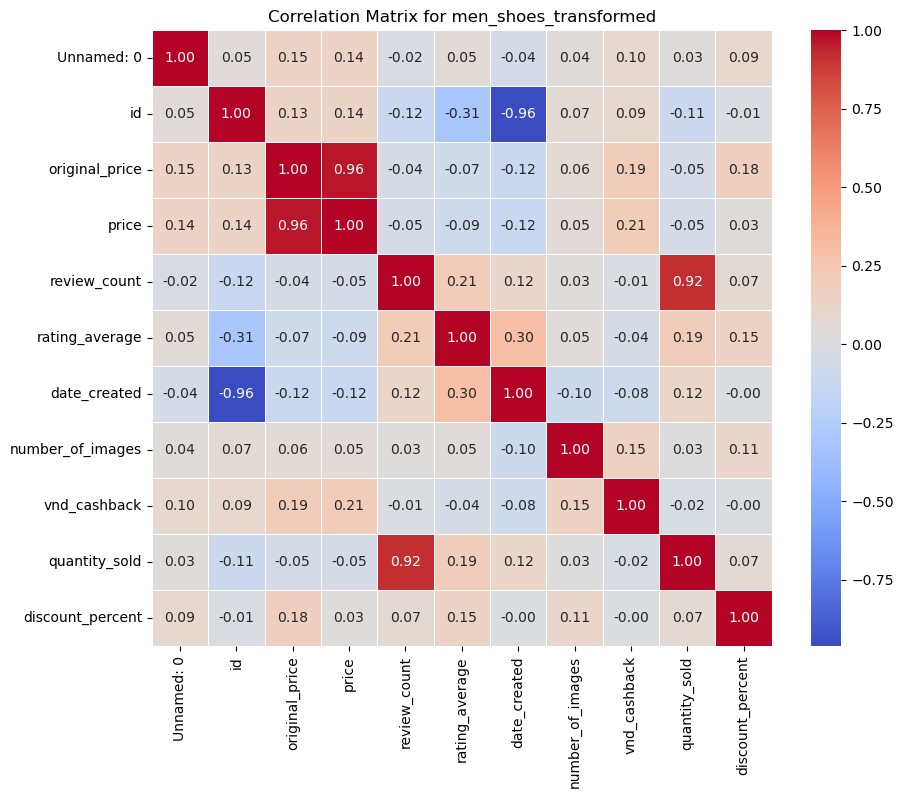

In [26]:
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

transformed_collections = [
    "men_shoes_transformed"
]

client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

def perform_eda(collection_name):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    print(f"Summary Statistics for {collection_name}:")
    print(data.describe(include='all')) 

    print(f"\nMissing values in {collection_name}:")
    print(data.isnull().sum())

    print(f"\nCorrelation analysis for {collection_name}:")
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    if len(numerical_columns) > 0:
        correlation_matrix = data[numerical_columns].corr()
        print(correlation_matrix)

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
        plt.title(f"Correlation Matrix for {collection_name}")
        plt.show()
    else:
        print("No numerical columns found for correlation analysis.")

for collection_name in transformed_collections:
    perform_eda(collection_name)

client.close()

Summary Statistics for women_bags_transformed:
         Unnamed: 0            id  \
count   4325.000000  4.325000e+03   
unique          NaN           NaN   
top             NaN           NaN   
freq            NaN           NaN   
mean    2162.000000  1.474194e+08   
std     1248.664286  5.910208e+07   
min        0.000000  1.754631e+06   
25%     1081.000000  1.036602e+08   
50%     2162.000000  1.525481e+08   
75%     3243.000000  1.889031e+08   
max     4324.000000  2.631973e+08   

                                                     name description  \
count                                                4325        4325   
unique                                               4032        3370   
top     Ví Nữ Cầm Tay Da Cao Cấp - Ví Cầm Tay - Ví Đựn...         ...   
freq                                                   16          45   
mean                                                  NaN         NaN   
std                                                   NaN         NaN 

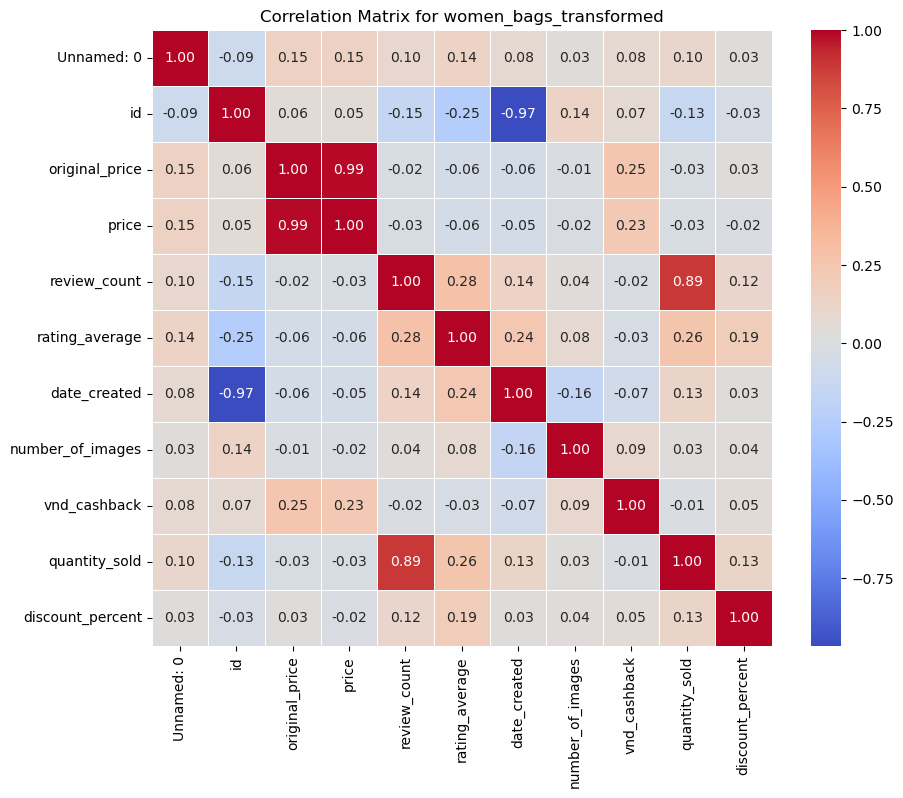

In [27]:

MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

transformed_collections = [
    "women_bags_transformed"
]

client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

def perform_eda(collection_name):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    print(f"Summary Statistics for {collection_name}:")
    print(data.describe(include='all'))  # Include all types for summary statistics

    # Check for missing values
    print(f"\nMissing values in {collection_name}:")
    print(data.isnull().sum())

    print(f"\nCorrelation analysis for {collection_name}:")
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    if len(numerical_columns) > 0:
        correlation_matrix = data[numerical_columns].corr()
        print(correlation_matrix)

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
        plt.title(f"Correlation Matrix for {collection_name}")
        plt.show()
    else:
        print("No numerical columns found for correlation analysis.")


for collection_name in transformed_collections:
    perform_eda(collection_name)

client.close()

Summary Statistics for women_shoes_transformed:
         Unnamed: 0            id                                 name  \
count   5919.000000  5.919000e+03                                 5919   
unique          NaN           NaN                                 5554   
top             NaN           NaN  Giầy da thật nữ cao cổ Martin 20410   
freq            NaN           NaN                                   12   
mean    2959.000000  1.509513e+08                                  NaN   
std     1708.812453  6.495821e+07                                  NaN   
min        0.000000  1.599010e+05                                  NaN   
25%     1479.500000  1.033231e+08                                  NaN   
50%     2959.000000  1.615611e+08                                  NaN   
75%     4438.500000  1.978585e+08                                  NaN   
max     5918.000000  2.631170e+08                                  NaN   

       description  original_price         price fulfillment_ty

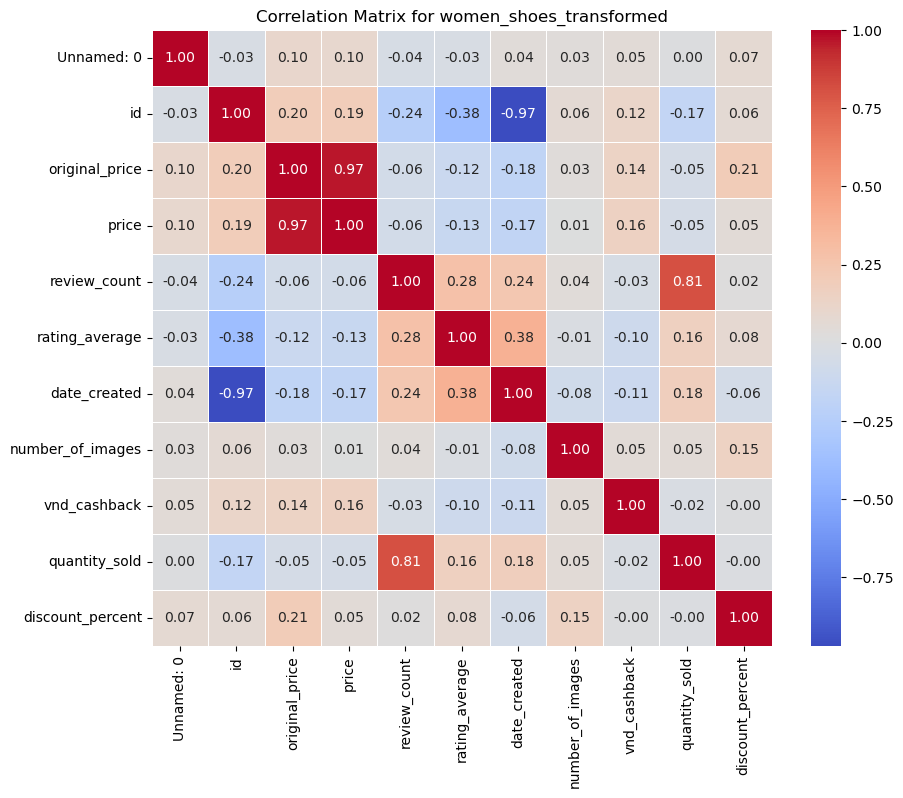

In [28]:
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

transformed_collections = [
    "women_shoes_transformed"
]

client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

def perform_eda(collection_name):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    print(f"Summary Statistics for {collection_name}:")
    print(data.describe(include='all'))

    print(f"\nMissing values in {collection_name}:")
    print(data.isnull().sum())

    print(f"\nCorrelation analysis for {collection_name}:")
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    if len(numerical_columns) > 0:
        correlation_matrix = data[numerical_columns].corr()
        print(correlation_matrix)

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
        plt.title(f"Correlation Matrix for {collection_name}")
        plt.show()
    else:
        print("No numerical columns found for correlation analysis.")

for collection_name in transformed_collections:
    perform_eda(collection_name)

client.close()

## Visualisation

In [16]:
import plotly.express as px
import pandas as pd
from pymongo import MongoClient

# MongoDB connection details
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

# Example function to create an interactive scatter plot with Plotly
def interactive_scatter_plot(collection_name, x_column, y_column):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))
    
    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    fig = px.scatter(data, x=x_column, y=y_column, title=f"{y_column} vs {x_column} in {collection_name}")
    fig.show()

# Example: Interactive scatter plot for 'price' vs 'discount_percent' in 'backpacks_suitcases_transformed'
interactive_scatter_plot("backpacks_suitcases_transformed", "price", "discount_percent")


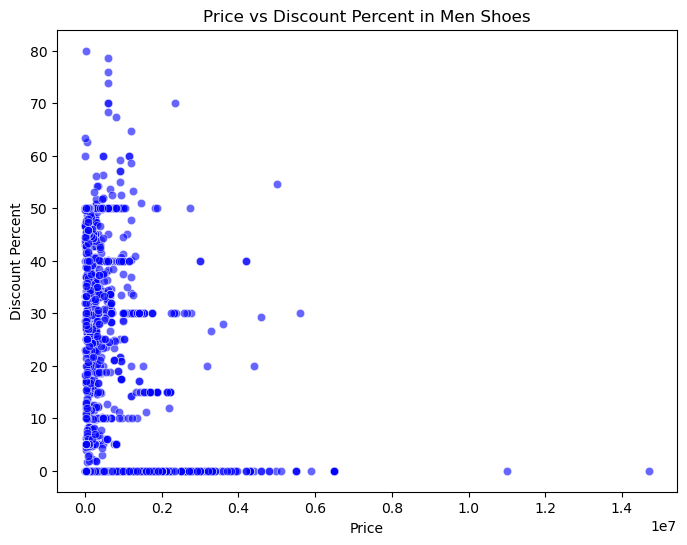

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pymongo import MongoClient

# MongoDB connection details
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

# Load data from the collection
collection = db['men_shoes_transformed']
data = pd.DataFrame(list(collection.find()))

if "_id" in data.columns:
    data = data.drop(columns=["_id"])

# Create scatter plot of price vs discount_percent
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['price'], y=data['discount_percent'], color='blue', alpha=0.6)
plt.title("Price vs Discount Percent in Men Shoes")
plt.xlabel("Price")
plt.ylabel("Discount Percent")
plt.show()

# Close MongoDB connection
client.close()


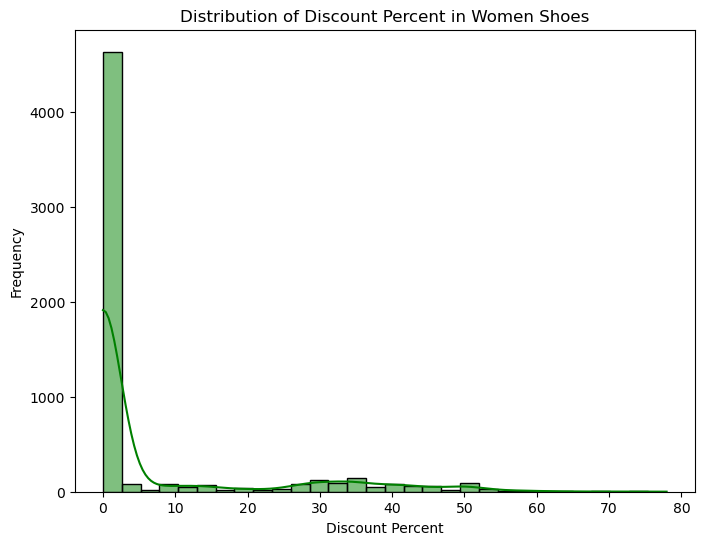

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pymongo import MongoClient

# MongoDB connection details
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

# Load data from the collection
collection = db['women_shoes_transformed']
data = pd.DataFrame(list(collection.find()))

if "_id" in data.columns:
    data = data.drop(columns=["_id"])

# Create histogram of discount_percent distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['discount_percent'], kde=True, bins=30, color='green')
plt.title("Distribution of Discount Percent in Women Shoes")
plt.xlabel("Discount Percent")
plt.ylabel("Frequency")
plt.show()

# Close MongoDB connection
client.close()


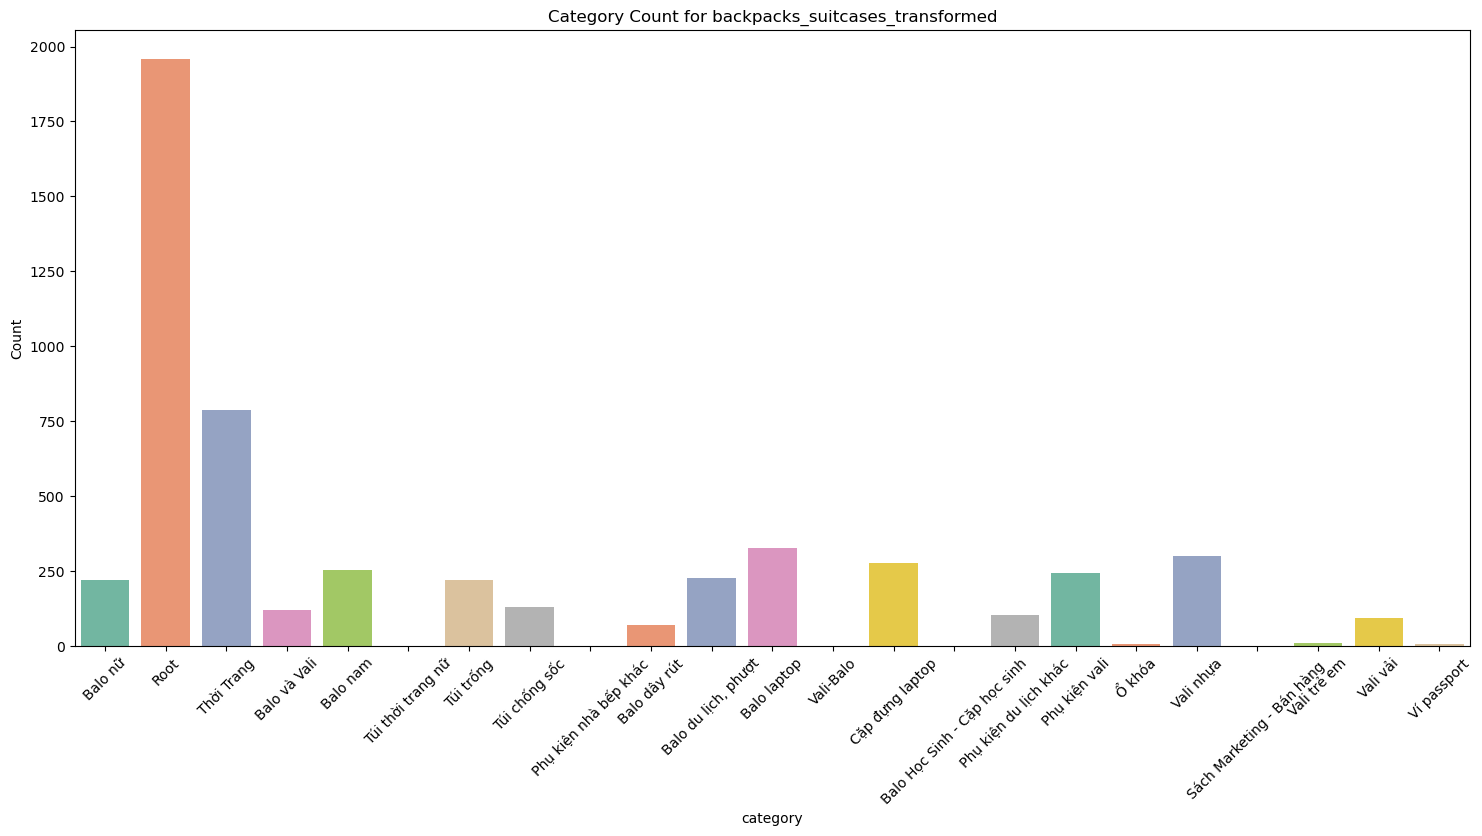

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pymongo import MongoClient

# MongoDB connection details
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

# Example: Countplot for the 'category' column in the 'backpacks_suitcases' collection
def plot_countplot(collection_name, category_column):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    plt.figure(figsize=(18, 8))
    sns.countplot(data=data, x=category_column, palette="Set2")
    plt.title(f"Category Count for {collection_name}")
    plt.xlabel(category_column)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# Example: Countplot for 'category' in 'backpacks_suitcases_transformed'
plot_countplot("backpacks_suitcases_transformed", "category")

# Close MongoDB connection
client.close()

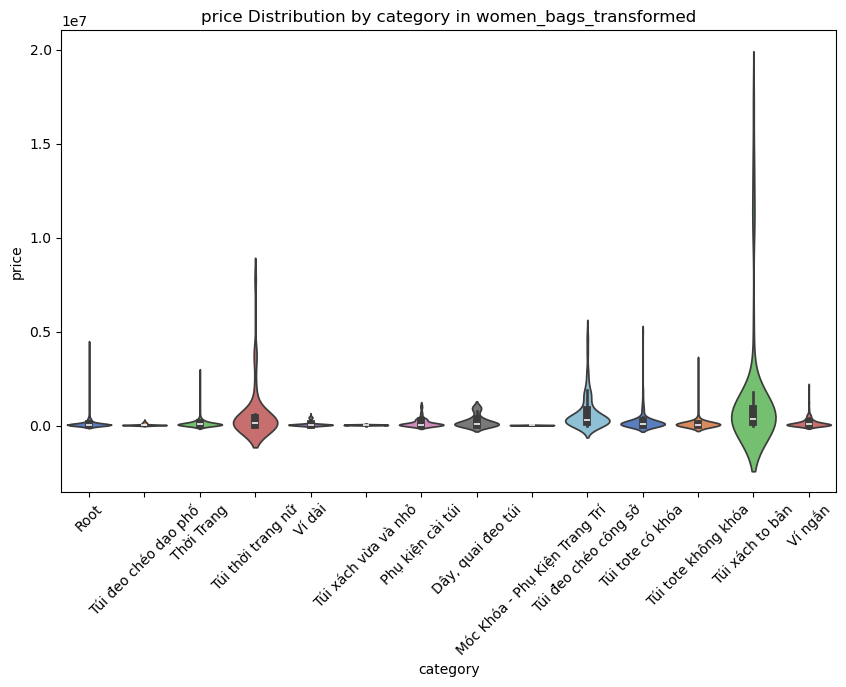

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pymongo import MongoClient

# MongoDB connection details
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

# Example: Violin plot of price distribution by category in 'women_bags'
def plot_violin_plot(collection_name, category_column, value_column):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=data[category_column], y=data[value_column], palette="muted")
    plt.title(f"{value_column} Distribution by {category_column} in {collection_name}")
    plt.xlabel(category_column)
    plt.ylabel(value_column)
    plt.xticks(rotation=45)
    plt.show()

# Example: Violin plot for 'price' by 'category' in 'women_bags_transformed'
plot_violin_plot("women_bags_transformed", "category", "price")

# Close MongoDB connection
client.close()

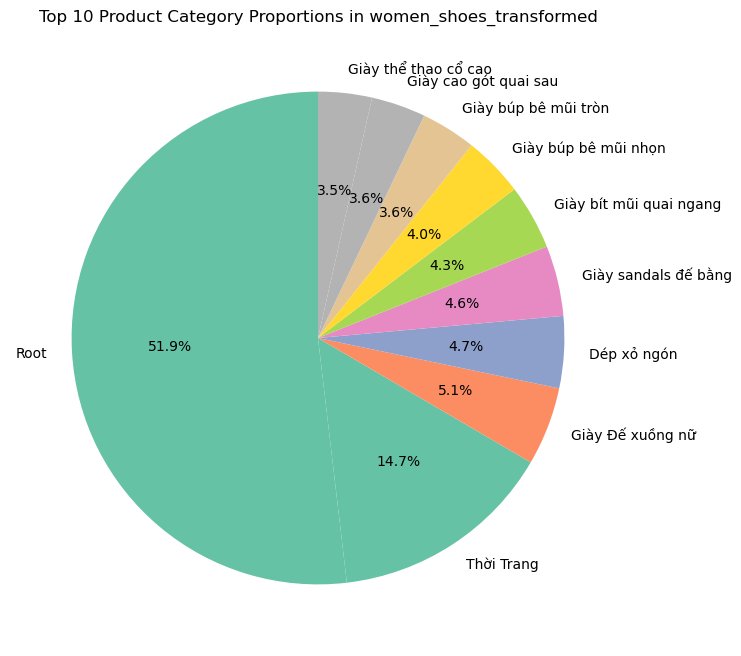

In [21]:
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "ecommerce_db"

client = MongoClient(MONGO_URI)
db = client[DATABASE_NAME]

# Pie chart of top 10 category proportions in 'women_shoes' collection
def plot_pie_chart(collection_name, category_column):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find()))

    if "_id" in data.columns:
        data = data.drop(columns=["_id"])

    top_categories = data[category_column].value_counts().head(10)

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    top_categories.plot.pie(autopct='%1.1f%%', startangle=90, cmap="Set2")
    plt.title(f"Top 10 Product Category Proportions in {collection_name}")
    plt.ylabel("")
    plt.show()

plot_pie_chart("women_shoes_transformed", "category")

# Close MongoDB connection
client.close()